<a href="https://colab.research.google.com/github/PrarthanMR/AWS-Lambda-Python/blob/master/algo_trading_setup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Algo Trading Setup

The Aim of the notebook is to verify different trade setup based on technical analysis tools such as candlestick pattern, indicators etc. To backtest and identify best trade setup.

**Todo**

1.   [x] Load NSE stock prices
2.   [x] Plot stock price as candlestick on chart
3.   [x] Backtest marobazu trade setup.
4.   [ ] Replicate equity delievery charges as commision
5.   [ ] Create HangingMan / Hammer Trade setup
6.   [ ] compute S&R
7.   [ ] fix yahoo finance for date calculation




### Load Necessary Libraries & Packages

TA-Lib package is a technical analysis library with 150+ technical indicator implementations.

Ta-Lib package needs a dependent C module installation. Command to install C module required for talib.

Ref - [stackoverflow answer](https://stackoverflow.com/questions/49648391/how-to-install-ta-lib-in-google-colab)


In [1]:
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
!wget $url/libta-lib0_0.4.0-oneiric1_amd64.deb -qO libta.deb
!wget $url/ta-lib0-dev_0.4.0-oneiric1_amd64.deb -qO ta.deb
!dpkg -i libta.deb ta.deb
!pip install TA-Lib


Selecting previously unselected package libta-lib0.
(Reading database ... 123599 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind_2_0.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_loader.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc_proxy.so.2 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbb.so.12 is not a symbolic link

/sb

In [ ]:
!pip install yfinance

     |████████████████████████████████| 6.4 MB 7.7 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
%pip install backtrader

     |████████████████████████████████| 410 kB 5.4 MB/s 


In [ ]:
import talib
import yfinance as yf
import backtrader as bt
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from datetime import datetime

In [ ]:
# matplotlib configurations
%matplotlib inline
plt.style.use('ggplot')

### Load stock prices

In [ ]:
def get_stock_data(symbol, start, end):
  ticker = yf.Ticker(symbol)
  df = ticker.history(start=start, end=end, auto_adjust=False, rounding=True, interval="15m")
  return df

In [ ]:
def get_stock_data_old(symbol, from_date, end_date):
  from_date_epoch = int(datetime.strptime(from_date, '%Y-%m-%d').timestamp())
  end_date_epoch = int(datetime.strptime(end_date, '%Y-%m-%d').timestamp())
  # print(from_date_epoch, end_date_epoch)
  data = pd.read_json(f'https://query1.finance.yahoo.com/v8/finance/chart/{symbol}.NS?period1={from_date_epoch}&period2={end_date_epoch}&interval=1d&frequency=1d&filter=history')
  result = data['chart']['result'][0]
  quotes = result['indicators']['quote'][0]
  df = pd.DataFrame(quotes)
  df['datetime'] = pd.to_datetime(result['timestamp'], unit='s')  # convert epoch to datetime
  df['date'] = df['datetime'].dt.strftime('%d-%m-%Y')  # convert datetime to dd-mm-yyyy format
  df.set_index('datetime', inplace=True)
  df = df.dropna()
  return df

In [ ]:
stock_data = get_stock_data('TCS.NS', '2022-01-01', '2022-02-15')
stock_data.head()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,,
2022-01-03 09:15:00+05:30,3748.35,3785.00,3745.45,3783.50,3783.50,187329,0.0,0
2022-01-03 09:30:00+05:30,3782.90,3809.85,3782.90,3804.00,3804.00,281740,0.0,0
2022-01-03 09:45:00+05:30,3804.10,3808.35,3793.10,3802.05,3802.05,117013,0.0,0
2022-01-03 10:00:00+05:30,3802.40,3803.95,3796.00,3800.15,3800.15,81673,0.0,0
2022-01-03 10:15:00+05:30,3801.45,3815.90,3799.00,3814.00,3814.00,169139,0.0,0


### View charts

In [ ]:
import plotly.express as px

def display_line_chart(data):
  fig = px.line(data, x=data.index, y="Close")
  fig.show()

In [ ]:
def display_candlestick_chart(data):
  candlestick_data = go.Candlestick(x=data.index,
                                  open=data['Open'],
                                  high=data['High'],
                                  low=data['Low'],
                                  close=data['Close'])
  fig = go.Figure(data=[candlestick_data])
  fig.show()

### Strategies

#### Base Strategy
Base strategy class which implements core functionalities which child classes may override if required

In [ ]:
class MyStrategy(bt.Strategy):
  """
  Overridden form of Backtrader Strategy to implement common functionalities
  """
  def __init__(self):
    # datas
    self.data_high = self.datas[0].high
    self.data_low = self.datas[0].low
    self.data_open = self.datas[0].open
    self.data_close = self.datas[0].close

    # ongoing order details
    self.order = None
    self.orefs = []

  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print(f'{dt.isoformat()} {txt}')

  def notify_trade(self, trade):
    if not trade.isclosed:
      return
    self.log("Trade Summary, gross: %.2f, net: %.2f, duration: %d\n" % (trade.pnl, trade.pnlcomm, trade.barlen))

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        # self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
        pass
      elif order.issell():
        # self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
        pass

    elif order.status in [order.Margin, order.Rejected]:
      self.log(f'Order failed({order.getstatusname()})')

#### Sample Strategy to print close price

In [ ]:
class PrintClose(bt.Strategy):
    def __init__(self):
        #Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datadate = self.datas[0].datetime

    def log(self, txt, close, dt):
        print(f'{txt} {dt.isoformat()} {close:.2f}') #Print date and close

    def next(self):
        # print(self.datas[0].datetime.date(0), end="  ")
        self.log('Close: ', self.dataclose[0], self.datadate.date(0))


#### Moving average crossover strategy

In [ ]:
class MACrossover(bt.Strategy):
  # moving average params
  params = (('pfast', 10), ('pslow', 20))

  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    # print(f'{dt.isoformat()} {txt}')

  def __init__(self):
    self.dataclose = self.datas[0].close

    # ongoing order details
    self.order = None

    self.slow_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pslow)
    self.fast_sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.pfast)

  def notify_order(self, order):
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status in [order.Completed]:
      if order.isbuy():
        self.log(f'BUY EXECUTED, {order.executed.price:.2f}')
      elif order.issell():
        self.log(f'SELL EXECUTED, {order.executed.price:.2f}')
      self.bar_executed = len(self)

    elif order.status in [order.Canceled, order.Margin, order.Rejected]:
      self.log('Order Canceled/Margin/Rejected')

    # Reset orders
    self.order = None

  def next(self):
    # Check for open orders
    if self.order:
      return

    # Check if we are in the market
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades

      #If the 20 SMA is above the 50 SMA
      if self.fast_sma[0] > self.slow_sma[0] and self.fast_sma[-1] < self.slow_sma[-1]:
        self.log(f'BUY Triggered, {self.dataclose[0]:2f}')
        # Keep track of the created order to avoid a 2nd order
        self.order = self.buy()
      #Otherwise if the 20 SMA is below the 50 SMA
      elif self.fast_sma[0] < self.slow_sma[0] and self.fast_sma[-1] > self.slow_sma[-1]:
        self.log(f'SELL Triggered, {self.dataclose[0]:2f}')
        # Keep track of the created order to avoid a 2nd order
        self.order = self.sell()
    else:
      # We are already in the market, look for a signal to CLOSE trades
      if len(self) >= (self.bar_executed + 5):
        self.log(f'CLOSE CREATE {self.dataclose[0]:2f}')
        self.order = self.close()


#### Test Strategy

In [ ]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

    def next(self):
        # Simply log the closing price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])

        if self.dataclose[0] < self.dataclose[-1]:
            # current close less than previous close

            if self.dataclose[-1] < self.dataclose[-2]:
                # previous close less than the previous close

                # BUY, BUY, BUY!!! (with all possible default parameters)
                self.log('BUY CREATE, %.2f' % self.dataclose[0])
                self.buy()

#### Buy And Hold Strategy

In [ ]:
class BuyAndHold(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy all the available cash
        size = int(self.broker.get_cash() / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print('ROI:        {:.2f}%'.format(100.0 * self.roi))

#### Marubozu Strategy

This strategy works on Marubozu candlestick pattern. A marubozu pattern is formed when candle is formed with only body and no shadow. It represents strong directional momentum in market.

* Result: Fails
* Strike rate: 26%
* ROI: -6.08%

In [ ]:
from datetime import timedelta

class MarubozuStrategy(MyStrategy):
  params = (
      ('rrr', 2),  # risk reward ratio
  )
  def __init__(self):
    super().__init__()

    # indicators
    self.marubozu = bt.talib.CDLMARUBOZU(self.data.open, self.data.high, self.data.low, self.data.close)

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades
      if self.marubozu[0] == 100:
        # strong buy momentum, open long position
        stoploss = self.data_low[0]  # Low of marubozu will act as stoploss
        target = (self.params.rrr * (self.data[0] - stoploss)) + self.data[0]
        self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}', self.datas[0].datetime.datetime(0) + timedelta(hours=5, minutes=30))
        os = self.buy_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]
      elif self.marubozu[0] == -100:
        # strong buy momentum, open long position
        stoploss = self.data_high[0]  # High of marubozu will act as stoploss
        target = self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
        self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}', self.datas[0].datetime.datetime(0) + timedelta(hours=5, minutes=30))
        os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

#### Hammer / Hanging Man strategy
This strategy is based on candlestick pattern formed with long lower shadow representing trend reversal.

* Result: Successful
* Strike Rate: 70.83%
* ROI: 11.44%

In [ ]:
class HammerStrategy(MyStrategy):
  params = (
      ('rrr', 1.5),  # risk reward ratio
  )
  def __init__(self):
    super().__init__()

    # indicators
    self.hammer = bt.talib.CDLHAMMER(self.data.open, self.data.high, self.data.low, self.data.close)
    self.hangingman = bt.talib.CDLHANGINGMAN(self.data.open, self.data.high, self.data.low, self.data.close)

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def get_support(self, price):
    return levels.loc[levels < price].max()

  def get_resistance(self, price):
    return levels.loc[levels > price].min()

  def is_close(self, price, level, range=5):
    return abs(price - level) < range


  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades
      if self.hammer[0] == 100 or self.hangingman[0] == 100:
        # trend reversal marking entry of bulls, open long position
        sp = self.get_support(self.data[0])
        rs = self.get_resistance(self.data[0])
        if self.is_close(self.data[0], sp):
          stoploss = min(self.data_low[0], sp)  # Low of hammer or support will act as stoploss
          target = rs # (self.params.rrr * (self.data[0] - stoploss)) + self.data[0]
          self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
          os = self.buy_bracket(exectype=bt.Order.Market, price=self.data[0], limitprice=target, stopprice=stoploss)
          self.orefs = [o.ref for o in os]

      elif self.hammer[0] == -100 or self.hangingman[0] == -100:
        # trend reversal marking entry of bears, open short position
        sp = self.get_support(self.data[0])
        rs = self.get_resistance(self.data[0])
        if self.is_close(self.data[0], rs):
          stoploss = max(self.data_high[0], rs)  # High of hanging man will act as stoploss
          target = sp # self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
          self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
          os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
          self.orefs = [o.ref for o in os]

#### Engulfing Pattern
This candle is a trend reversal pattern.
1. Stock is in downtrend.
2. P1 candle is another red candle.
3. P2 candle is blue candle such that it completely engulfs previous candle.

Vice-versa for bearish engulfing pattern.

In [ ]:
class EngulfingStrategy(MyStrategy):
  params = (
      ('rrr', 1.5),  # risk reward ratio
      ('trend_period', 14),
      ('strength_threshold', 25)
  )
  def __init__(self):
    super().__init__()

    # indicators
    self.engulfing = bt.talib.CDLENGULFING(self.data.open, self.data.high, self.data.low, self.data.close)
    # Add directional indicator to identify trend
    self.plus_di = bt.talib.PLUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.minus_di = bt.talib.MINUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.trend_strength = bt.talib.ADX(self.data_high, self.data_low, self.data_close, timeperiod=self.params.trend_period)

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market

    if self.engulfing[0] == 100:
      self.log(f'bullish minus_di{self.minus_di[0]:.2f}, plus_di{self.plus_di[0]:.2f}, trend_strength{self.trend_strength[0]:.2f}')
    if self.engulfing[0] == -100:
      self.log(f'bearish minus_di{self.minus_di[0]:.2f}, plus_di{self.plus_di[0]:.2f}, trend_strength{self.trend_strength[0]:.2f}')
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades
      if self.minus_di[0] > self.plus_di[0] and self.trend_strength > self.params.strength_threshold and self.engulfing[0] == 100:
        # trend reversal marking entry of bulls, open long position
        stoploss = min(self.data_low[0], self.data_low[-1])  # Minumum low of p1 or p2 will act as stoploss
        target = (self.params.rrr * (self.data[0] - stoploss)) + self.data[0]
        self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.buy_bracket(exectype=bt.Order.Market, price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

      elif self.plus_di[0] > self.minus_di[0] and self.trend_strength > self.params.strength_threshold and self.engulfing[0] == -100:
        # trend reversal marking entry of bears, open short position
        stoploss = max(self.data_high[0], self.data_high[-1])  # Max High of p1 or p2 man will act as stoploss
        target = self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
        self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

#### Morning Star Pattern
This candle is a trend reversal pattern.
1. Stock is in downtrend.
2. P1 candle is another red candle.
3. P2 candle is gap down opening forming doji or spinning top.
3. P3 candle has gap up opening forming blue candle.

Vice-versa for evening star pattern.

In [ ]:
class MorningStarPattern(MyStrategy):
  params = (
      ('rrr', 1.5),  # risk reward ratio
      ('trend_period', 7),
      ('strength_threshold', 25)
  )
  def __init__(self):
    super().__init__()

    # indicators
    self.morning_star = bt.talib.CDLMORNINGSTAR(self.data.open, self.data.high, self.data.low, self.data.close)
    self.evening_star = bt.talib.CDLEVENINGSTAR(self.data.open, self.data.high, self.data.low, self.data.close)
    # Add directional indicator to identify trend
    self.plus_di = bt.talib.PLUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.minus_di = bt.talib.MINUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.trend_strength = bt.talib.ADX(self.data_high, self.data_low, self.data_close, timeperiod=self.params.trend_period)

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market
    if not self.position:
      if self.morning_star[0] == 100 or self.morning_star[0] == -100:
        self.log(f'morning star formed minus_di{self.minus_di[0]:.2f}, plus_di{self.plus_di[0]:.2f}, trend_strength{self.trend_strength[0]}')
      if self.evening_star[0] == 100 or self.evening_star[0] == -100:
        self.log(f'evening_star {self.evening_star[0]} formed minus_di{self.minus_di[0]:.2f}, plus_di{self.plus_di[0]:.2f}, trend_strength{self.trend_strength[0]}')
      # We are not in the market, look for a signal to OPEN trades
      if self.minus_di[0] > self.plus_di[0] and self.trend_strength[0] > self.params.strength_threshold and self.morning_star[0] == 100:
        # trend reversal marking entry of bulls, open long position
        stoploss = min(self.data_low[0], self.data_low[-1])  # Minumum low of p1 or p2 will act as stoploss
        target = (self.params.rrr * (self.data[0] - stoploss)) + self.data[0]
        self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.buy_bracket(exectype=bt.Order.Market, price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

      elif self.plus_di[0] > self.minus_di[0] and self.trend_strength[0] > self.params.strength_threshold and self.evening_star[0] == -100:
        # trend reversal marking entry of bears, open short position
        stoploss = max(self.data_high[0], self.data_high[-1])  # Max High of p1 or p2 man will act as stoploss
        target = self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
        self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

#### 3 Soldiers

In [ ]:
class ThreeSoldiers(MyStrategy):
  params = (
      ('rrr', 1.5),  # risk reward ratio
      ('trend_period', 7),
      ('strength_threshold', 25)
  )
  def __init__(self):
    super().__init__()
    # indicators
    self.white_soldiers = bt.talib.CDL3WHITESOLDIERS(self.data.open, self.data.high, self.data.low, self.data.close)
    # Add directional indicator to identify trend
    self.plus_di = bt.talib.PLUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.minus_di = bt.talib.MINUS_DI(self.data.high, self.data.low, self.data_close, timeperiod=self.params.trend_period)
    self.trend_strength = bt.talib.ADX(self.data_high, self.data_low, self.data_close, timeperiod=self.params.trend_period)

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades
      if self.white_soldiers[0] == 100:
        # trend reversal marking entry of bulls, open long position
        stoploss = min(self.data_low[0], self.data_low[-1])  # Minumum low of p1 or p2 will act as stoploss
        target = (self.params.rrr * (self.data[0] - stoploss)) + self.data[0]
        self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.buy_bracket(exectype=bt.Order.Market, price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

      elif self.white_soldiers[0] == -100:
        # trend reversal marking entry of bears, open short position
        stoploss = max(self.data_high[0], self.data_high[-1])  # Max High of p1 or p2 man will act as stoploss
        target = self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
        self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

In [ ]:
# Support and resistance strategy
class SupportResistanceStrategy(MyStrategy):
  params = (
      ('rrr', 1.5),  # risk reward ratio
      ('trend_period', 7),
      ('strength_threshold', 25)
  )
  def __init__(self):
    super().__init__()

  def notify_order(self, order):
    super().notify_order(order)
    if order.status in [order.Submitted, order.Accepted]:
      return

    if order.status == order.Completed:
      self.holdstart = len(self)

    if not order.alive() and order.ref in self.orefs:
      self.orefs.remove(order.ref)

  def get_support(self, price):
    return levels.loc[levels < price].max()

  def get_resistance(self, price):
    return levels.loc[levels > price].min()

  def is_close(self, price, level, range=2):
    return abs(price - level) < range

  def next(self):
    if self.orefs:
      return #pending orders do nothing

    # Check if we are in the market
    if not self.position:
      # We are not in the market, look for a signal to OPEN trades
      sp = self.get_support(self.data[0])
      rs = self.get_resistance(self.data[0])
      if self.is_close(self.data[0], sp):
        # trend reversal marking entry of bulls, open long position
        stoploss = sp  # Minumum low of p1 or p2 will act as stoploss
        target = rs
        self.log(f'Long : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.buy_bracket(exectype=bt.Order.Market, price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

      elif self.is_close(self.data[0], rs):
        # trend reversal marking entry of bears, open short position
        stoploss = rs  # Max High of p1 or p2 man will act as stoploss
        target = sp # self.data[0] - (self.params.rrr * (stoploss - self.data[0]))
        self.log(f'Short : {self.data[0]:.2f}, Target: {target:.2f}, Stoploss: {stoploss:.2f}')
        os = self.sell_bracket(price=self.data[0], limitprice=target, stopprice=stoploss)
        self.orefs = [o.ref for o in os]

#### Buy On Dip
Result with invest perc: [1,2,4,8,16,32,64,84,100]
Starting Portfolio Value: 2160000.00
Final Portfolio Value: 4538775.33
PnL: 2378775.33
ROI %: 110.13



In [ ]:
class BuyOnDipStrategy(MyStrategy):
    def __init__(self):
        super().__init__()
        self.last_max_price = 0
        self.levels = [29,39,49,59,69,109,149,20,30]
        self.is_trade_initiated = [False for i in range(len(self.levels))]
        self.invest_amount = [5000, 10000, 15000, 25000, 40000, 65000, 105000, 170000, 275000]
        self.invest_perc = [5,8,13,17,21,34,55,80,100]

    def _reset(self):
        self.is_trade_initiated = [False for i in range(len(self.levels))]

    def notify_order(self, order):
        super().notify_order(order)
        if order.status in [order.Submitted, order.Accepted]:
            return

        if order.status == order.Completed:
            self.holdstart = len(self)

        if not order.alive() and order.ref in self.orefs:
            self.orefs.remove(order.ref)

    def next(self):
        self.last_max_price = max(self.last_max_price, self.data_close[0])
        drawdown = ((self.last_max_price - self.data_close[0]) / self.last_max_price) * 100
        if drawdown > 2:
            for i in range(len(self.levels)):
                if drawdown >= self.levels[i] and self.is_trade_initiated[i] is False:
                    # order = self.order_target_value(target=self.invest_amount[i] * 3)
                    # order = self.buy(size=1)
                    percent_of_portfolio_value = self.invest_perc[i] / 100
                    self.order_target_percent(target=percent_of_portfolio_value)
                    self.is_trade_initiated[i] = True
        elif drawdown == 0 and self.is_trade_initiated[0] is True:
            self.log(self.broker.get_cash())
            self.close()
            self._reset()


#### SIP Strategy

In [ ]:
class SIPStrategy(MyStrategy):
    def __init__(self):
        super().__init__()
        self.salary = 16000
        self.invest_amount = 16000

    def notify_order(self, order):
        super().notify_order(order)

    def next(self):
        dt = self.data.datetime.date()
        if dt.day == 10:
            self.broker.add_cash(self.salary)
        if dt.day == 15:
            self.buy(size=1)


### Backtest

In [ ]:
def fetch_data(symbol, start_date, end_date):
  """
  fetch stock data and display charts
  """
  stock_data = get_stock_data(symbol, start_date, end_date)
  stock_data.head()
  display_line_chart(stock_data)
  return stock_data

In [ ]:
def init_stat():
  # instantiate cerebero engine
  cerebro = bt.Cerebro()

  # Default position size
  cerebro.addsizer(bt.sizers.AllInSizerInt)

  # set broker commission as 11.16 per 10k (refer zerodha brokerage calculator)
  # TODO: Add Rs. 15.93 (DP Charges on sell side)
  # cerebro.broker.setcommission(commission=0.00116)

  # to allow short order with stoploss
  cerebro.broker.set_checksubmit(checksubmit=False)

  # initial cash
  cerebro.broker.setcash(50000)

  return cerebro

In [ ]:
def run_stat(df, strategy):
  cerebro = init_stat()

  # add data feeds to data engine
  data = bt.feeds.PandasData(dataname=stock_data, openinterest=None)
  cerebro.adddata(data)

  # add strategy to engine
  cerebro.broker.set_fundmode(True)
  cerebro.addstrategy(strategy)

  # initial cash stats
  start_portfolio_value = cerebro.broker.getvalue()

  # add analyzer
#   cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name = "ta")
  cerebro.addanalyzer(bt.analyzers.TimeReturn)

  # run engine
  strats= cerebro.run()
  cerebro.plot()

#   printTradeAnalysis(strats[0].analyzers.ta.get_analysis())

  # evaluating PnL
  end_portfolio_value = cerebro.broker.getvalue()
  pnl = end_portfolio_value - start_portfolio_value
  print(f'Starting Portfolio Value: {start_portfolio_value:.2f}')
  print(f'Final Portfolio Value: {end_portfolio_value:.2f}')
  print(f'PnL: {pnl:.2f}')
  print(f'ROI %: {((pnl / start_portfolio_value) * 100):.2f}')

In [ ]:
run_stat(stock_data, MarubozuStrategy)

2022-01-03T12:00:00 Short : 3803.05, Target: 3785.45, Stoploss: 3811.85
2022-01-03 Trade Summary, gross: -114.40, net: -114.40, duration: 1

2022-01-03T13:15:00 Short : 3812.90, Target: 3799.30, Stoploss: 3819.70
2022-01-03 Trade Summary, gross: -78.65, net: -78.65, duration: 1

2022-01-04T10:00:00 Long : 3848.00, Target: 3873.10, Stoploss: 3835.45
2022-01-04 Trade Summary, gross: -150.60, net: -150.60, duration: 1

2022-01-05T11:30:00 Short : 3824.70, Target: 3808.10, Stoploss: 3833.00
2022-01-05 Trade Summary, gross: -125.40, net: -125.40, duration: 1

2022-01-05T13:30:00 Long : 3854.15, Target: 3865.85, Stoploss: 3848.30
2022-01-05 Trade Summary, gross: 141.00, net: 141.00, duration: 2

2022-01-05T14:45:00 Short : 3850.20, Target: 3832.70, Stoploss: 3858.95
2022-01-05 Trade Summary, gross: -129.60, net: -129.60, duration: 1

2022-01-06T10:15:00 Short : 3811.15, Target: 3795.15, Stoploss: 3819.15
2022-01-06 Trade Summary, gross: 192.00, net: 192.00, duration: 4

2022-01-06T12:00:00 S

### Analysis

#### Trade Analysis

In [ ]:
def printTradeAnalysis(analyzer):
  try:
    total_open = analyzer.total.open
    total_closed = analyzer.total.closed
    total_won = analyzer.won.total
    total_lost = analyzer.lost.total
    win_streak = analyzer.streak.won.longest
    lost_streak = analyzer.streak.lost.longest
    pnl_net = round(analyzer.pnl.net.total,2)
    strike_rate = round((total_won/total_closed)*100, 2) if total_closed > 0 else 0

    h1 = ["Total Open", "Total Closed", "Total Won", "Total Lost"]
    h2 = ["Strike Rate", "Win Streak", "Losing Streak", "PnL Net"]
    r1 = [total_open, total_closed, total_won, total_lost]
    r2 = [strike_rate, win_streak, lost_streak, pnl_net]
    if len(h1) > len(h2):
      header_length = len(h1)
    else:
      header_length = len(h2)

    print_list = [h1,r1,h2,r2]
    row_format = "{:<15}" * (header_length+1)
    print("Trade Analysis Results:")
    for row in print_list:
      print(row_format.format("", *row))
  except KeyError as e:
    print("No Analysis as no trade is taken")


### Evaluate

In [ ]:
# Enter various trade parameters
symbol = '^NSEI'  # refer yahoo finance for symbol
start = '2010-01-01'
end = '2021-12-20'

# fetch stock data from yahoo finance API
stock_data = fetch_data(symbol, start, end)

2010-01-18 Order failed(Margin)


<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

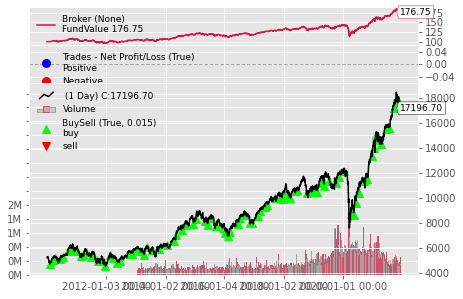

In [ ]:
# run_stat(stock_data, SIPStrategy)
cerebro = init_stat()

# add data feeds to data engine
data = bt.feeds.PandasData(dataname=stock_data, openinterest=None)
cerebro.adddata(data)

# add strategy to engine
cerebro.broker.set_fundmode(True)
cerebro.addstrategy(SIPStrategy)

# initial cash stats
start_portfolio_value = cerebro.broker.getvalue()

# add analyzer
#   cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name = "ta")
cerebro.addanalyzer(bt.analyzers.TimeReturn)

# run engine
strats= cerebro.run()
%matplotlib inline
cerebro.plot()

In [ ]:
class SupportAndResistance:
  def __init__(self):
    self.period = 10
    # self.data = data

  def identify_levels(self, data):
    threshold = (data['High'] - data['Low']).mean()
    result = []
    levels = self.get_reversal_prices(data)
    print(f"Range==> : {threshold:.2f}, total pivots: {len(levels)}")
    i = 0
    while i < len(levels):
      price = levels[i]
      j = i + 1
      while j < len(levels):
        if abs(levels[j] - price) <= threshold:
          price = (price + levels[j]) / 2
        else:
          break
        j += 1
      result.append(round(price,1))
      i = j
    return pd.Series(result)

  def plot(self, data):
    # line chart
    fig_line = px.line(data, x=data.index, y="Close")
    levels = self.get_reversal_prices(data)
    zones = self.identify_levels(data)

    fig = go.Figure(
        [
         go.Candlestick(
             x=data.index,
             open=data.Open,
             high=data.High,
             low=data.Low,
             close=data.Close,
             name='Chart'
         ),
         go.Scatter(
             x=levels.index,
             y=levels,
             mode="markers",
             marker_color="blue",
             name="Pivot points"
         )
        ]
    )
    threshold = (data['High'] - data['Low']).mean()
    noise = threshold / 4
    for z in zones:
      col = "green" if z[0] < data['Close'][-1] else "red"
      fig.add_hrect(y0=z[0]-noise, y1=z[0]+noise, line_width=0,fillcolor=col, opacity=(1 - .8 / z[1]))

    fig.show()

  def get_reversal_prices(self, data):
    down = self.get_downtrend_reversal_prices(data)
    up = self.get_uptrend_reversal_prices(data)
    return pd.concat([down, up]).rename("Level").sort_values()

  def get_downtrend_reversal_prices(self, data):
    prev_low = data['Low'].rolling(self.period).min().shift(1)
    next_low = data['Low'].rolling(self.period).min().shift(-self.period + 1)
    mask = (data['Low'] <= prev_low) & (data['Low'] <= next_low)
    return data['Low'].loc[mask]

  def get_uptrend_reversal_prices(self, data):
    prev_high = data['High'].rolling(self.period).max().shift(1)
    next_high = data['High'].rolling(self.period).max().shift(-self.period + 1)
    mask = (data['High'] >= prev_high) & (data['High'] >= next_high)
    return data['High'].loc[mask]


In [ ]:
snr = SupportAndResistance()
levels = snr.identify_levels(stock_data.loc["2016-01-01": "2018-12-31"])

Range==> : 88.90, total pivots: 41


In [ ]:
!pip install plotly --upgrade
import plotly
plotly.__version__

'4.4.1'

In [ ]:
levels.loc[levels > 650].max()

11760.2

### Nifty Buy at Dip strategy

In [ ]:
data = get_stock_data("^NSEI", "2010-1-1", "2021-12-31")
data.describe()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
count,2920.000000,2920.000000,2920.000000,2920.000000,2920.000000,2.920000e+03,2920.0,2920.0
mean,8688.583185,8733.156524,8628.610120,8681.498716,8681.498716,2.239973e+05,0.0,0.0
std,3120.960429,3130.271741,3101.844054,3117.004648,3117.004648,2.254740e+05,0.0,0.0
min,4623.150000,4623.150000,4531.150000,4544.200000,4544.200000,0.000000e+00,0.0,0.0
25%,5872.312500,5906.475000,5827.350000,5868.275000,5868.275000,0.000000e+00,0.0,0.0
50%,8260.275000,8307.425000,8215.500000,8261.700000,8261.700000,1.728000e+05,0.0,0.0
75%,10752.675000,10794.912500,10691.337500,10741.400000,10741.400000,2.958250e+05,0.0,0.0
max,18602.350000,18604.450000,18445.300000,18477.050000,18477.050000,1.811000e+06,0.0,0.0


In [ ]:
cummax = data['Close'].cummax()
max_drawdown = data['Close'].cummax() - data['Close']
max_drawdown_perc = round(((data['Close'].cummax() - data['Close']) / data['Close'].cummax()) * 100, 2)

In [ ]:
max_drawdown = data['Close'].cummax() - data['Close']

In [ ]:
max_drawdown_perc = round((max_drawdown / data['Close'].cummax()) * 100, 2)

In [ ]:
result = []
mx_draw = 0
mx_draw_index = None
for i in range(len(data)):
  if  max_drawdown_perc[i] > mx_draw:
    mx_draw = max(mx_draw, max_drawdown_perc[i])
    mx_draw_index = i
  if data['Close'][i] >= cummax[i] and mx_draw >= 1:
    time_taken = i - mx_draw_index
    result.append((mx_draw, data.index[mx_draw_index].strftime('%d-%m-%Y'), data.index[i].strftime('%d-%m-%Y'), (data.index[i] - data.index[mx_draw_index]).days))
    mx_draw = 0
    mx_draw_index = None
len(result)

49

In [ ]:
result.sort()
result

[(1.0, '13-08-2018', '17-08-2018', 4),
 (1.01, '31-03-2010', '05-04-2010', 5),
 (1.18, '26-12-2019', '02-01-2020', 7),
 (1.19, '01-07-2021', '07-07-2021', 6),
 (1.2, '09-07-2021', '15-07-2021', 6),
 (1.29, '19-11-2020', '24-11-2020', 5),
 (1.31, '17-08-2010', '19-08-2010', 2),
 (1.32, '20-09-2021', '23-09-2021', 3),
 (1.41, '22-03-2017', '30-03-2017', 8),
 (1.45, '23-05-2019', '24-05-2019', 1),
 (1.5, '30-07-2010', '04-08-2010', 5),
 (1.51, '25-11-2020', '01-12-2020', 6),
 (1.54, '12-10-2010', '13-10-2010', 1),
 (1.73, '24-05-2017', '26-05-2017', 2),
 (1.74, '19-04-2017', '25-04-2017', 6),
 (1.78, '16-04-2014', '21-04-2014', 5),
 (1.81, '01-10-2021', '08-10-2021', 7),
 (1.83, '20-07-2021', '03-08-2021', 14),
 (1.86, '30-05-2014', '03-06-2014', 4),
 (1.9, '28-06-2017', '10-07-2017', 12),
 (2.13, '23-06-2014', '02-07-2014', 9),
 (2.15, '18-01-2021', '20-01-2021', 2),
 (2.35, '06-01-2020', '13-01-2020', 7),
 (2.42, '10-12-2019', '17-12-2019', 7),
 (2.55, '31-08-2010', '06-09-2010', 6),
 (

In [ ]:
buy_drawdown_levels = [2, 3, 4, 5, 6, 10, 14,20, 30]

In [ ]:
invest_amount = [5000, 10000]
for i in range(len(buy_drawdown_levels) - 2):
  invest_amount.append(invest_amount[-1] + invest_amount[-2])
invest_amount

[5000, 10000, 15000, 25000, 40000, 65000, 105000, 170000, 275000]

In [ ]:
lst = []
for i in range(len(buy_drawdown_levels)):
  lst.append((buy_drawdown_levels[i], invest_amount[i]))
df = pd.DataFrame(lst, columns=['drawdown_perc', 'invest_amount'])

In [ ]:
df['sell_amount'] = df['invest_amount'] * 100 / (100 - df['drawdown_perc'])
df['profit'] = df['sell_amount'] - df['invest_amount']
df['profit_perc'] = (df['profit'] * 100) / df['invest_amount']
df['occurence'] = [6,4,4,4,3,4,1,2,2]
df['cum_occ'] = df.loc[::-1, 'occurence'].cumsum()[::-1]
df

,drawdown_perc,invest_amount,sell_amount,profit,profit_perc,occurence,cum_occ
0,2,5000,5102.040816,102.040816,2.040816,6,30
1,3,10000,10309.278351,309.278351,3.092784,4,24
2,4,15000,15625.000000,625.000000,4.166667,4,20
3,5,25000,26315.789474,1315.789474,5.263158,4,16
4,6,40000,42553.191489,2553.191489,6.382979,3,12
5,10,65000,72222.222222,7222.222222,11.111111,4,9
6,14,105000,122093.023256,17093.023256,16.279070,1,5
7,20,170000,212500.000000,42500.000000,25.000000,2,4
8,30,275000,392857.142857,117857.142857,42.857143,2,2


In [ ]:
((df['sell_amount'].sum() - df['invest_amount'].sum()) * 100) / df['invest_amount'].sum()

26.701082882403796

In [ ]:
df['sell_amount'].sum() - df['invest_amount'].sum()

189577.68846506695

In [ ]:
(df['profit'] * df['cum_occ']).sum()

630854.2363468102

In [ ]:
list(df['invest_amount'])

[5000, 10000, 15000, 25000, 40000, 65000, 105000, 170000, 275000]

In [ ]:
plt.plot([1,2,3])
plt.show()

In [ ]:
plt.plot([1, 2, 3, 4], [1, 4, 2, 3])
plt.show()

### SIP Strategy

In [ ]:
symbol = '^NSEI'  # refer yahoo finance for symbol
start = '2010-01-01'
end = '2021-12-20'

# fetch stock data from yahoo finance API
data = get_stock_data(symbol, start, end)

In [ ]:
invested_amount = data['Close'].sum()
portfolio_value = data['Close'][-1] * data['Close'].count()
print(f"Invested: {invested_amount}, Value: {portfolio_value}")

Invested: 25349976.25, Value: 50214364.0


In [ ]:
from datetime import datetime
then = datetime(2010, 1, 1)        # Random date in the past
now  = datetime(2019, 12, 31)                         # Now
duration = now - then                         # For build-in functions
duration_in_s = duration.total_seconds()
year = divmod(duration_in_s, 31536000)[0]


10.0

In [ ]:
cagr = round(((data['Close'][-1] / data['Close'][0]) ** (1 / year) - 1) * 100, 2)
abs_return = round((data['Close'][-1] / data['Close'][0]) * 100, 2)
abs_return

328.67

### 15 Minute Marubozu Strategy

On a 15 Minute chart if a marubozu candle is formed than take a position in same direction.

In [ ]:
display_line_chart(stock_data)

In [ ]:
stock_data.tail()

,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,,
2022-02-14 14:30:00+05:30,1694.35,1697.25,1692.10,1696.60,1696.60,339834,0,0
2022-02-14 14:45:00+05:30,1696.20,1698.00,1687.20,1687.90,1687.90,395101,0,0
2022-02-14 15:00:00+05:30,1687.70,1688.80,1678.75,1683.45,1683.45,843081,0,0
2022-02-14 15:15:00+05:30,1683.50,1687.00,1678.30,1684.00,1684.00,837542,0,0
2022-02-15 15:30:00+05:30,1738.25,1738.25,1738.25,1738.25,1738.25,0,0,0


In [ ]:
from datetime import datetime, timedelta
import time

In [ ]:
now_timestamp = time.time()
offset = datetime.fromtimestamp(now_timestamp) - datetime.utcfromtimestamp(now_timestamp)
print(datetime.now() + timedelta(hours=5, minutes=30))

2022-02-15 23:52:00.178711
